### Two datasets with a similar motif

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import multibind as mb
import numpy as np
import pandas as pd

import torch
import torch.optim as topti
import torch.utils.data as tdata

# Use a GPU if available, as it should be faster.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

Using device: cpu


In [3]:
train1, test1 = mb.tl.create_multi_data(n_chip=2000, n_selex=0) # , n_selex=100)


prepare mononuc feats...
prepare dinuc feats...
prepare mononuc feats...
prepare dinuc feats...


In [4]:
# train1.dataset.is_count_data = np.repeat(False, train1.dataset.target.shape[0])

In [5]:
# pd.Series(train1.dataset.target).describe()

### Using cooptf/screr (this will be deprecated and replace by bindome).

### If treating y data as log, the convergence gets to the GATA motif in small sequences.

In [6]:
# train1.dataset.target = np.log(train1.dataset.target)

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

<AxesSubplot:xlabel='batch', ylabel='y'>

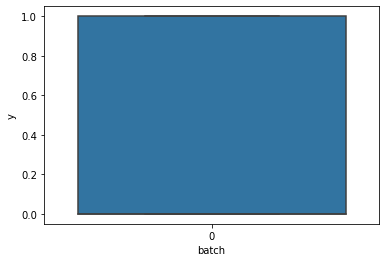

In [8]:
df = pd.DataFrame()
df['y'] = train1.dataset.target
df['batch'] = np.array(train1.dataset.batch)
sns.boxplot(data=df, x='batch', y='y')

In [9]:
df.sort_values('y', ascending=False)

,y,batch
0,1.0,0
1328,1.0,0
1326,1.0,0
1325,1.0,0
1324,1.0,0
...,...,...
2632,0.0,0
2631,0.0,0
2630,0.0,0
2629,0.0,0


In [10]:
n_datasets = np.unique(df['batch']).shape[0]
n_datasets

1

In [11]:
net2 = mb.models.DinucMulti(use_dinuc=False, n_datasets=n_datasets, w=7).to(device)
net2.dataset.weight.data.uniform_(1, 1) # initialize weights as ones.

tensor([[1.]])

In [12]:
mononuc = torch.Tensor(train1.dataset.mononuc) # .type(torch.float32)
dinuc = torch.Tensor(train1.dataset.dinuc) # .type(float32)
b = torch.Tensor(train1.dataset.batch).to(torch.int64)
y_true = torch.Tensor(train1.dataset.target)

inputs = (mononuc, dinuc, b)
y_pred = net2(inputs).detach().numpy()

In [13]:
# train1.dataset.batch.shape, train1.dataset.mononuc.shape
# net2.conv_mono(torch.unsqueeze(torch.Tensor(train1.dataset.mononuc), 1))[0].squeeze()

In [14]:
mononuc[train1.dataset.is_count_data.values == 1]

tensor([], size=(0, 4, 200))

In [15]:
# a, b = inputs[is_count_data == 1], inputs[is_count_data == 0]        
# print(a.shape, b.shape)


# poisson_loss = torch.mean(targets[is_count_data == 1] - a*torch.log(targets[is_count_data == 1]))
# bce_loss = torch.nn.BCELoss(b, targets[is_count_data == 0])

# print(poisson_loss, bce_loss)
# assert False

In [16]:
m = torch.nn.Sigmoid()
bce = torch.nn.BCELoss()
x = torch.Tensor([0, 1])
targets = torch.Tensor([0, 1])
bce(m(x), targets)

tensor(0.5032)

In [17]:
m = torch.nn.Sigmoid()
loss = torch.nn.BCELoss()
input = torch.randn(3, requires_grad=True)
target = torch.empty(3).random_(2)
output = loss(m(input), target)
print(input, target)
output.backward()
print(output)

tensor([-1.3393, -0.5587, -0.2902], requires_grad=True) tensor([0., 0., 0.])
tensor(0.4145, grad_fn=<BinaryCrossEntropyBackward>)


In [18]:
optimiser = topti.Adam(net2.parameters(), lr=0.001, weight_decay=0.0001)
criterion = mb.tl.MultiDatasetLoss()
l2 = []
l2 += mb.tl.train_network(net2, train1, device, optimiser, criterion, num_epochs=5000, log_each=100)

Epoch:  1, Loss: 50.378
Epoch: 101, Loss: 0.693
Epoch: 201, Loss: 0.694
Epoch: 301, Loss: 0.694
Epoch: 401, Loss: 0.694
Epoch: 501, Loss: 0.694


KeyboardInterrupt: 

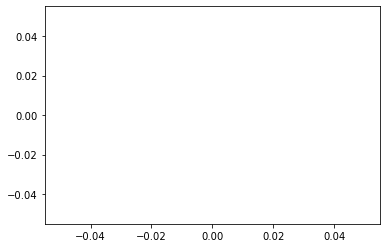

In [19]:
plt.plot(l2)

In [21]:
## check the batch effects
net2.dataset.weight

Parameter containing:
tensor([[-0.0006]], requires_grad=True)

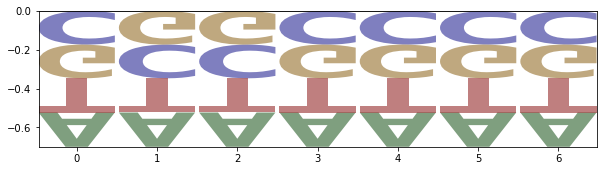

In [22]:
# print(np.exp(net2.log_weight_1.squeeze().cpu().detach().numpy()))
# print(np.exp(net.log_weight_2.squeeze().cpu().detach().numpy()))
#mb.tl.create_logo(net)
#plt.show()
#mb.tl.create_heatmap(net)
import logomaker
weights = net2.conv_mono.weight
weights = weights.squeeze().cpu().detach().numpy()
weights = pd.DataFrame(weights)
weights.index = 'A', 'C', 'G', 'T'
crp_logo = logomaker.Logo(weights.T, shade_below=.5, fade_below=.5)

In [23]:
from sklearn.metrics import r2_score

In [24]:
print('here...')

here...


In [25]:
net2.dataset.weight

Parameter containing:
tensor([[-0.0006]], requires_grad=True)

### Check the quality of the predictions, across datasets

In [ ]:
mononuc = torch.Tensor(train1.dataset.mononuc).to(device)
dinuc = torch.Tensor(train1.dataset.dinuc).to(device)
b = torch.Tensor(train1.dataset.batch).to(torch.int64)
y_true = torch.Tensor(train1.dataset.target)
inputs = (mononuc, dinuc, b)
y_pred = net2(inputs).detach().numpy()

In [ ]:
import seaborn as sns
from sklearn.metrics import r2_score

In [ ]:
r2_score(y_true, y_pred)

In [ ]:
plt.scatter(y_true, y_pred, s=5, c=b)
plt.xlabel('observed')
plt.ylabel('predicted')

In [ ]:
print('here...')